# Reproducibility assessment of read alignment tools
## This is a draft (should be adapted once the naming convention is correct)

In [37]:
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from natsort import natsorted, natsort_keygen
import re
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from venn import venn


## Set up working directory, sampled ids, and replicate types

In [2]:
csv_dir="./sample_input/bam_results/"

sample_ids=["ERR009308", 
            "ERR009309", 
            "ERR009332", 
            "ERR009345", 
            "ERR013101"]

replicates=["both1", 
           "both2", 
           "both3", 
           "sh1", 
           "sh2", 
           "sh3", 
           "rc"]

# working_directory should contain a separate folder for each tools
tools = sorted([entry.name for entry in os.scandir(csv_dir) if entry.is_dir()])
print(f'Detected tools in {csv_dir}:\n {tools}')

Detected tools in ./sample_input/bam_results/:
 ['bowtie2', 'bwa2', 'hisat2', 'minimap2', 'ngm', 'smalt', 'snap', 'subread']


In [3]:
l = [[1,2,3],[4,5,6]]
flattened_l = [item for sublist in l for item in sublist]
print(flattened_l)

[1, 2, 3, 4, 5, 6]


In [4]:
# list of csv_files within the tool directories 
csv_files = list(chain.from_iterable([glob.glob(f'{csv_dir}{tool}/*.csv') for tool in tools]))

In [5]:
# read csv files into dataframe, add selected samp IDs and replicates to the dataframe

dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    filename = os.path.splitext(os.path.basename(file))[0]
    tool_name = os.path.basename(os.path.dirname(file))
    df['tool'] = tool_name
    
    for rep_type in replicates:
        if rep_type in filename:
            df['replicate'] = rep_type
            break
    
    for sid in sample_ids:
        if sid in filename:
            df['sampID'] = sid
        
    dataframes.append(df)
    
df_combined = pd.concat(dataframes)
df_combined = df_combined.sort_values(["tool", "sampID" ,"replicate"], key=natsort_keygen())

# reproducibility assessment metrics
features = df_combined['FEATURE'].unique()

In [6]:
# pivot dataframe to prepare for pplots

df_pivot = df_combined.pivot(index=['tool', 'replicate', 'sampID'], values='PERCENTAGE', columns='FEATURE')
df = df_pivot.reset_index()

# average percentages for the same replicate types
df['repType'] = df['replicate'].apply(lambda x: re.sub(r'\d+', '', x))
avg_df = df.groupby(['repType', 'sampID', 'tool'])[features].mean().reset_index()
replicate_types = avg_df['repType'].unique()

# add new results (differences among some metrics)
avg_df['non-identical'] = 100-avg_df['Identical']
avg_df['Uncommon_unambigous'] = 100-avg_df['Common_unambiguous']

avg_df.head()


FEATURE,repType,sampID,tool,Total_reads,Mapped_reads,Unambigous_type1,Unambigous_type2,Common_unambiguous,Inconsistent_type1,Inconsistent_type2,...,Consistent_global_inconsistent_local,Inconsistent_global,Multi_mapped,Mapped_reads_type1,Mapped_reads_type2,Common_mapped_reads,Unambiguous_type1,Unambiguous_type2,non-identical,Uncommon_unambigous
0,both,ERR009308,bowtie2,100.0,98.779,82.002,69.843,69.165,0.310,0.178,...,0.536000,3.110000,0.340000,NaN,NaN,NaN,NaN,NaN,4.473,30.835
1,both,ERR009308,bwa2,100.0,NaN,NaN,NaN,100.000,0.002,0.001,...,0.065333,0.699333,3.810333,99.698,99.696,99.699,100.0,100.0,4.578,0.000
2,both,ERR009308,hisat2,100.0,90.053,95.027,92.129,91.883,0.020,0.018,...,0.039000,0.364000,0.376000,NaN,NaN,NaN,NaN,NaN,0.817,8.117
3,both,ERR009308,minimap2,100.0,99.212,100.000,100.000,100.000,0.098,0.040,...,0.004000,6.624000,9.211000,NaN,NaN,NaN,NaN,NaN,15.976,0.000
4,both,ERR009308,ngm,100.0,99.579,100.000,100.000,100.000,0.000,0.000,...,0.000000,0.010000,0.012000,NaN,NaN,NaN,NaN,NaN,0.022,0.000


## Bar plots for reproducibility metrics
### to be completed, improved if necessary (@Belin and @Mike)

In [7]:
# bar plot with error bars
def plot_bar_err(data_df, info, category, label, line, val=None):
#     plt.figure()
    plt.figure(figsize=(14, 6))

    ax=sns.barplot(x = "tool", y = info, hue = category, data = data_df,
                palette = 'Set1',
                order = tools, 
                capsize=0.05,  errwidth=2, ci='sd')
    if line:
        ax.axhline(val, color='black', linestyle='--')
    ax.set(xlabel='tools', ylabel=label)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.legend(bbox_to_anchor=(1, 1))

In [8]:
# cat plot to distinguish multiple groups
def plot_cat(data_df, category, xval, label):
    
    
    df_melted = data_df.melt(category, var_name='values')
#     df_melted['value'] = 100-df_melted['value']
#     print(df_melted)
    
    sns.set(style='whitegrid')
    g=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,
                  palette='Set1',
                  order=tools, 
                  capsize=0.05, errwidth=2, ci='sd', kind='bar'
                 )
    
#     ax.set(xlabel='tools', ylabel=label)
    g.set_axis_labels("replicate types", label)
    g.set_xticklabels(tools)
    g.set_titles("replicate type = {col_name}")
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
#     g.legend(bbox_to_anchor=(1, 1))


/var/folders/49/sm5dm49n3hsb62mf46qv8g4r0000gn/T/ipykernel_93295/1118659363.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,


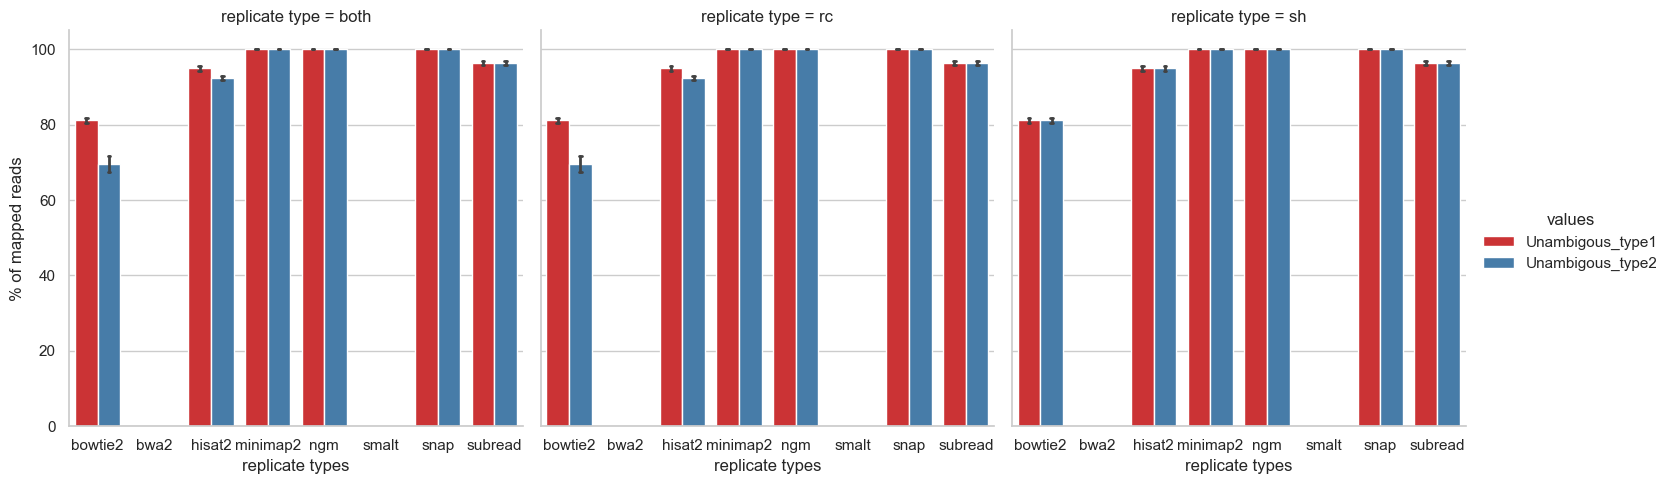

In [9]:
plot_cat(avg_df[['repType', 'sampID', 'tool', 'Unambigous_type1', 'Unambigous_type2']], 
              ['tool', 'repType', 'sampID'], 'tool', '% of mapped reads')


/var/folders/49/sm5dm49n3hsb62mf46qv8g4r0000gn/T/ipykernel_93295/2391955203.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax=sns.barplot(x = "tool", y = info, hue = category, data = data_df,


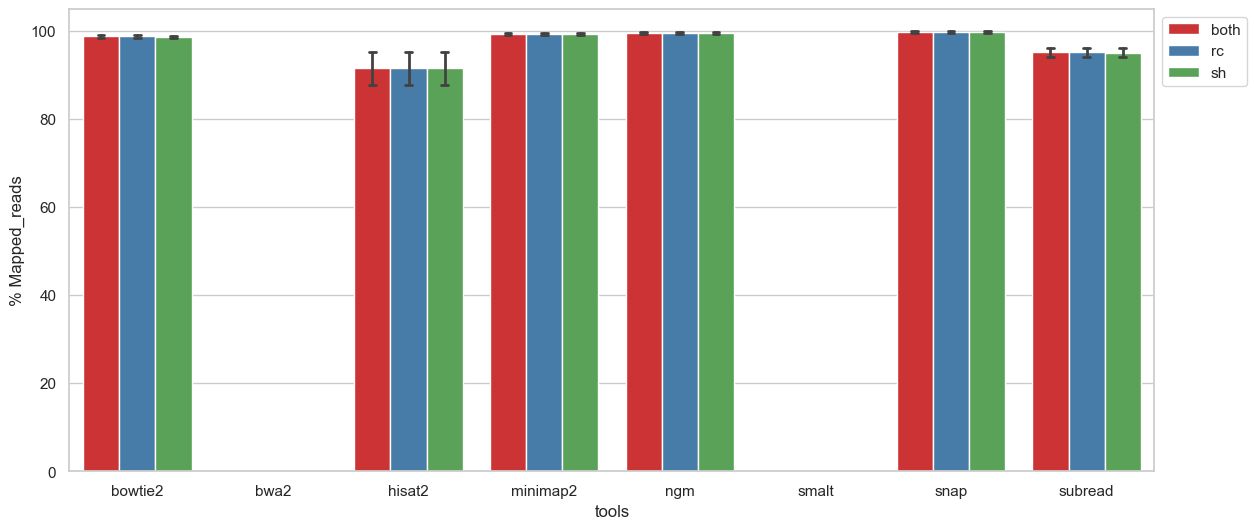

In [10]:
plot_bar_err(avg_df, 'Mapped_reads', 'repType' ,'% Mapped_reads', False, 5)


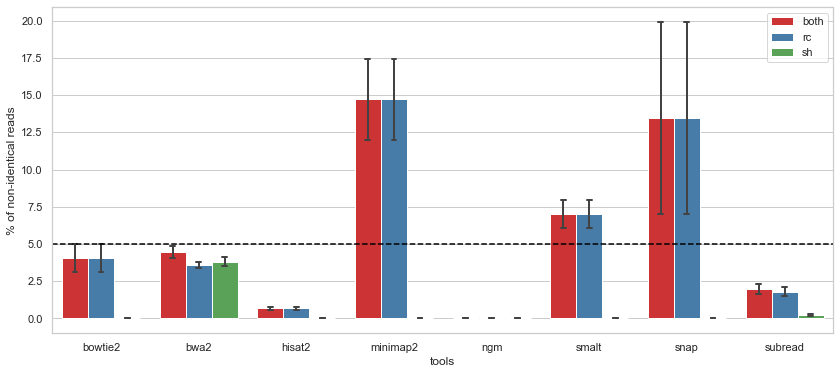

In [11]:
plot_bar_err(avg_df, 'non-identical', 'repType' ,'% of non-identical reads', True, 5)


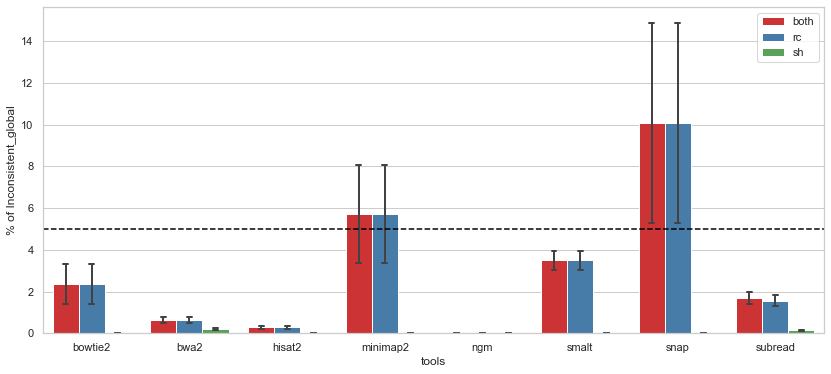

In [12]:
plot_bar_err(avg_df, 'Inconsistent_global', 'repType', '% of Inconsistent_global', True, 5)


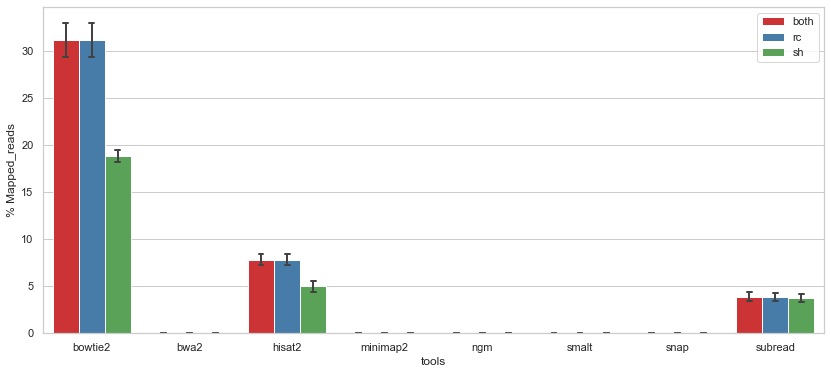

In [13]:
plot_bar_err(avg_df, 'Uncommon_unambigous', 'repType' ,'% Mapped_reads', False, 5)


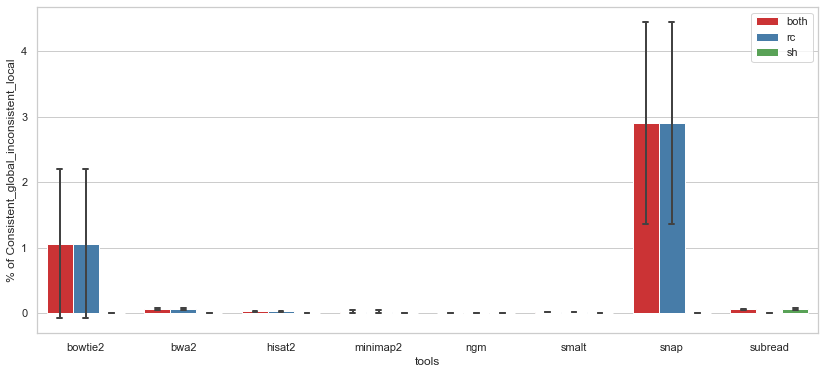

In [14]:
plot_bar_err(avg_df, 'Consistent_global_inconsistent_local', 
             'repType', '% of Consistent_global_inconsistent_local', False)


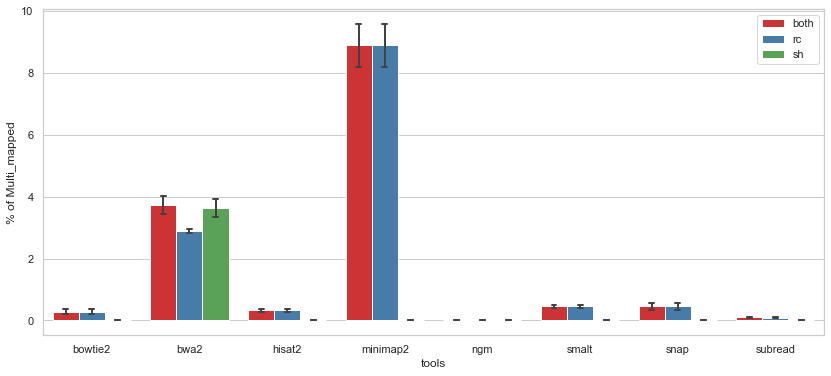

In [15]:
plot_bar_err(avg_df, 'Multi_mapped', 'repType', '% of Multi_mapped', False)

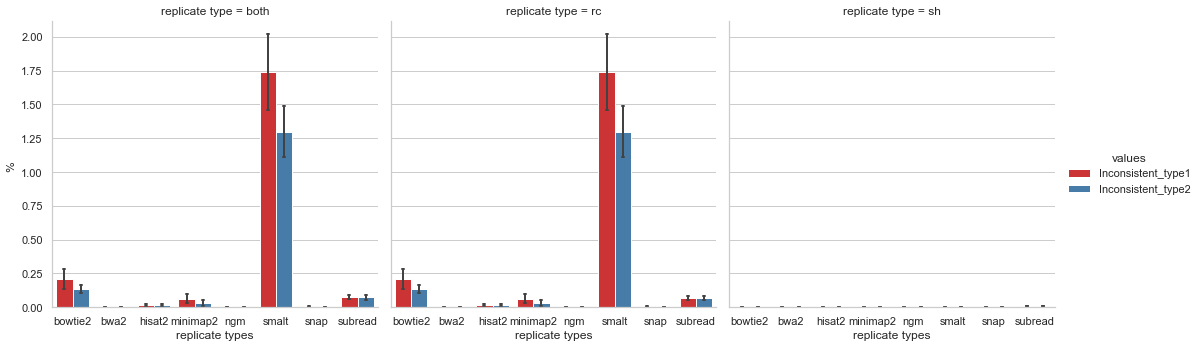

In [16]:
plot_cat(avg_df[['repType', 'sampID', 'tool', 'Inconsistent_type1', 'Inconsistent_type2']], 
              ['tool', 'repType', 'sampID'], 'tool', '% ')

In [17]:
avg_df


FEATURE,repType,sampID,tool,Total_reads,Mapped_reads,Unambigous_type1,Unambigous_type2,Common_unambiguous,Inconsistent_type1,Inconsistent_type2,Identical,Consistent_global_inconsistent_local,Inconsistent_global,Multi_mapped,non-identical,Uncommon_unambigous
0,both,ERR009308,bowtie2,100.0,98.779,82.002,69.843000,69.165000,0.310000,0.178000,95.527,0.536000,3.110000,0.340000,4.473,30.835000
1,both,ERR009308,bwa2,100.0,99.699,100.000,100.000000,100.000000,0.002000,0.001000,95.422,0.065333,0.699333,3.810333,4.578,0.000000
2,both,ERR009308,hisat2,100.0,90.053,95.027,92.129000,91.883000,0.020000,0.018000,99.183,0.039000,0.364000,0.376000,0.817,8.117000
3,both,ERR009308,minimap2,100.0,99.212,100.000,100.000000,100.000000,0.098000,0.040000,84.024,0.004000,6.624000,9.211000,15.976,0.000000
4,both,ERR009308,ngm,100.0,99.579,100.000,100.000000,100.000000,0.000000,0.000000,99.978,0.000000,0.010000,0.012000,0.022,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,sh,ERR013101,minimap2,100.0,99.211,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000
116,sh,ERR013101,ngm,100.0,99.047,100.000,100.000000,100.000000,0.000000,0.000000,99.992,0.000000,0.001333,0.006667,0.008,0.000000
117,sh,ERR013101,smalt,100.0,92.658,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000
118,sh,ERR013101,snap,100.0,99.649,100.000,100.000000,100.000000,0.000000,0.000000,100.000,0.000000,0.000000,0.000000,0.000,0.000000


In [18]:
features
# avg_df

array(['Total_reads', 'Mapped_reads', 'Unambigous_type1',
       'Unambigous_type2', 'Common_unambiguous', 'Inconsistent_type1',
       'Inconsistent_type2', 'Identical',
       'Consistent_global_inconsistent_local', 'Inconsistent_global',
       'Multi_mapped'], dtype=object)

## Venn diagrams (@ Mike)

In [48]:
bwa_venn_dir="./sample_input/bwa_venn/"
read_types = sorted([entry.name[:-6] for entry in os.scandir(bwa_venn_dir) if entry.is_file()])
ivenn_files = list(chain.from_iterable([glob.glob(f'{bwa_venn_dir}{read_type}.ivenn') for read_type in read_types]))

def plot_venn_diagram(sets: list, names: set):
    venn(dict(zip(names, sets)), fmt="{percentage:.1f}%", fontsize=10)

Read type: IG
Read type: MM


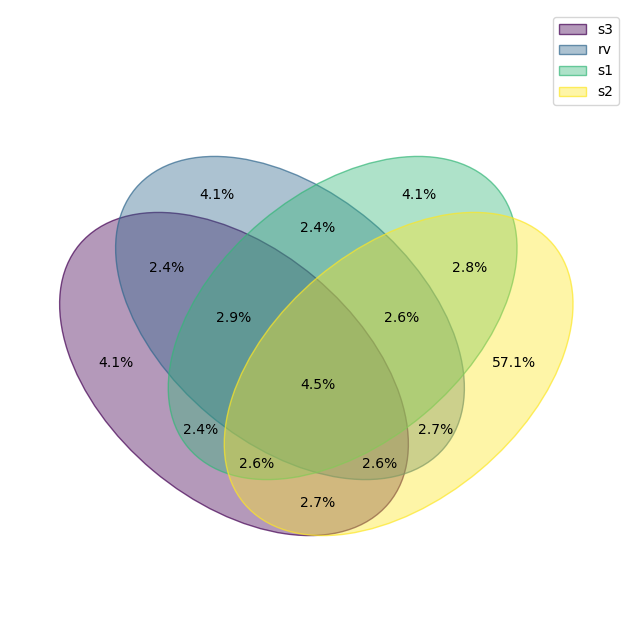

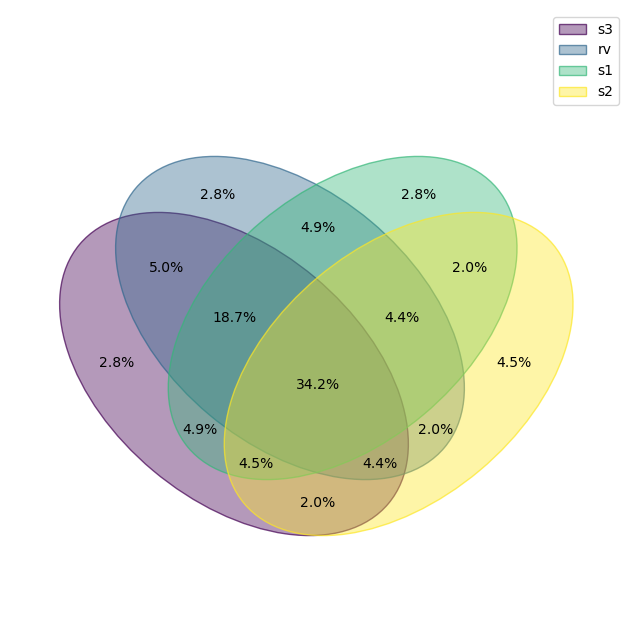

In [50]:
for idx, ivenn_file in enumerate(ivenn_files):
    print(f"Read type: {read_types[idx]}")
    with open(ivenn_file, 'r') as ivenn:
        sets = []
        names = set()
        for line in ivenn.readlines():
            compared_type = line[2:4]
            positions = [int(pos) for pos in line[5:-2].split(",")]
            sets.append(set(positions))
            names.add(compared_type)
        plot_venn_diagram(sets, names)

## Violing plots for position difference (@Mike)

In [28]:
true_pos_dir="./sample_input/true_position/"
true_pos_tools = sorted([entry.name[:-4] for entry in os.scandir(true_pos_dir) if entry.is_file()])

true_pos_csv_files = list(chain.from_iterable([glob.glob(f'{true_pos_dir}{tool}.csv') for tool in true_pos_tools]))

In [27]:
def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [54]:
def plot_radar(read_types: list, tool_name: str, matched_percentage_g: list, matched_percentage_rc: list):

    data = [read_types, (tool_name, [matched_percentage_g, matched_percentage_rc])]

    N = len(data[0])
    theta = radar_factory(N, frame='polygon')

    spoke_labels = data.pop(0)
    title, case_data = data[0]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)

    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title,  position=(0.5, 1.1), ha='center')

    for d in case_data:
        line = ax.plot(theta, d)
        ax.fill(theta, d, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    plt.show()

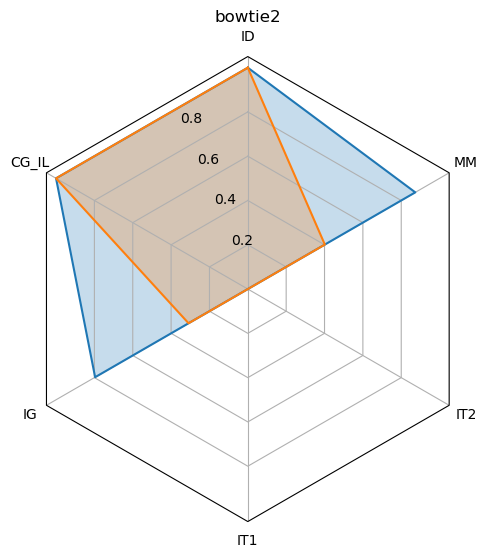

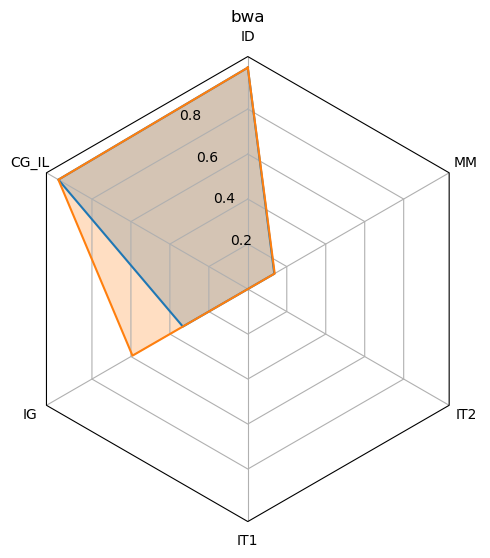

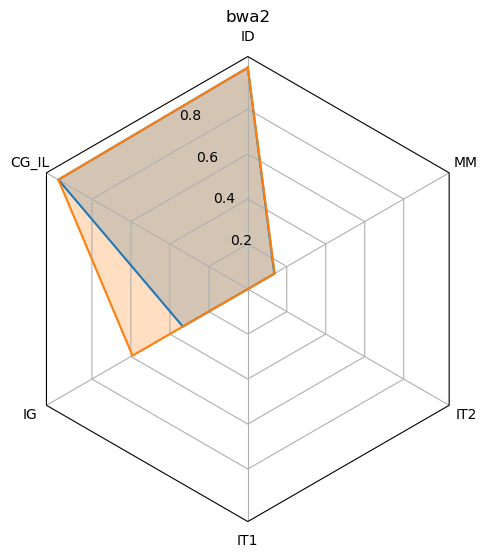

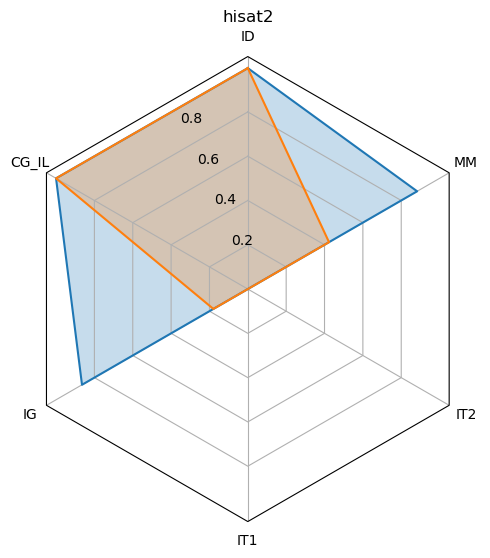

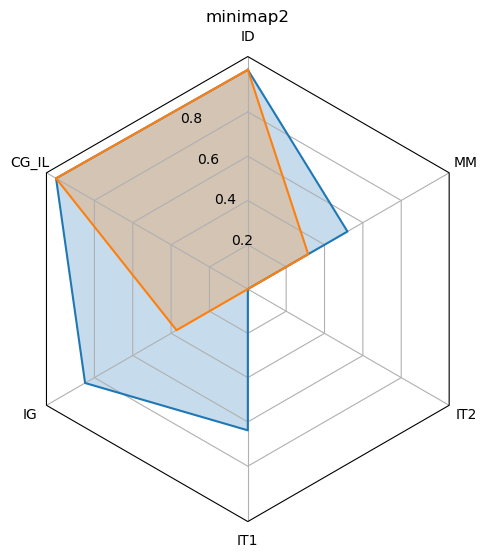

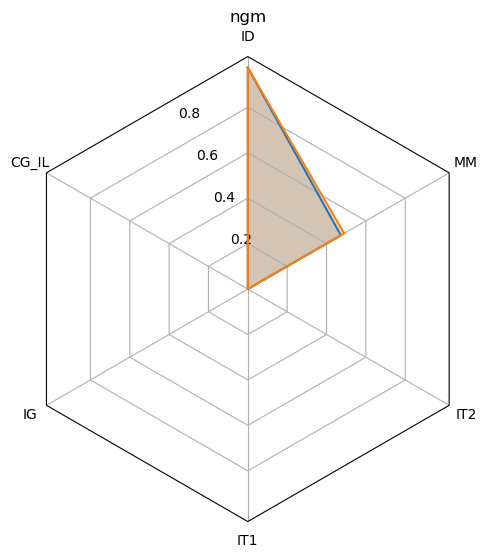

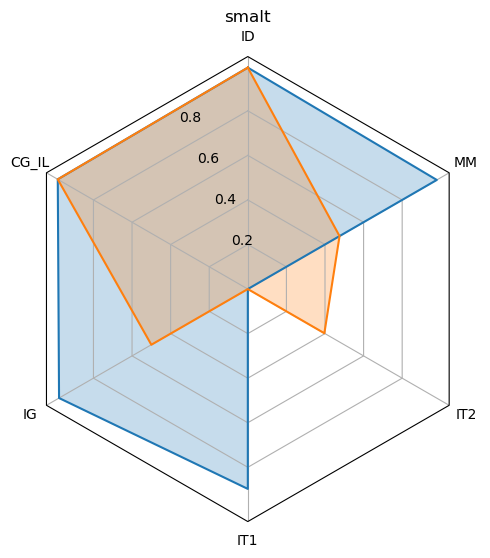

In [55]:
for file in true_pos_csv_files:
    df = pd.read_csv(file)
    tool_name = os.path.splitext(os.path.basename(file))[0]
    plot_radar(df.reads_type.tolist(), tool_name, df.matched_percentage_g.tolist(), df.matched_percentage_rc.tolist())

## CPU, run time, etc. violin plots (@Belin)
### Below is an example with two tools, should be done for all tools and indexing
### we should decide if it is worth reporting by replicate type

In [138]:
stats_file = "/Users/peicer/projects/github_releases/reproducibility/notebooks/sample_input/stats_results/tools_stats.csv"

In [139]:
df_stats = pd.read_csv(stats_file)
df_stats[df_stats['tool'] == 'ngm']['ram'].unique()
df_stats.head()

,Unnamed: 0,tool,sampID,repType,cpu,ram,utime
0,0,minimap2,ERR009308,g,1.042944,11.956,0.920551
1,1,minimap2,ERR009308,rc,1.578615,11.956,1.426988
2,2,minimap2,ERR009308,sh1,1.359512,11.956,1.201292
3,3,minimap2,ERR009308,sh2,0.974518,11.956,0.854226
4,4,minimap2,ERR009308,both1,2.050003,11.956,1.874380


In [140]:
df_stats['repType'] = df_stats['repType'].apply(lambda x: re.sub(r'\d+', '', x))
avg_df_stats = df_stats.groupby(['tool', 'sampID', 'repType'])['cpu', 'ram', 'utime'].mean().reset_index()
avg_df_stats['repType'].unique()
avg_df_stats.head()


/var/folders/b_/j2rtwzb11zld_833hqj9381h0000gr/T/ipykernel_3875/2063186492.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_df_stats = df_stats.groupby(['tool', 'sampID', 'repType'])['cpu', 'ram', 'utime'].mean().reset_index()


,tool,sampID,repType,cpu,ram,utime
0,minimap2,ERR009308,both,1.699052,11.956000,1.568528
1,minimap2,ERR009308,g,1.042944,11.956000,0.920551
2,minimap2,ERR009308,rc,1.578615,11.956000,1.426988
3,minimap2,ERR009308,sh,1.087752,11.956000,0.965357
4,minimap2,ERR009309,both,1.277425,12.081333,1.169250


In [141]:
avg_df_stats[(avg_df_stats['tool'] == 'minimap2') & (avg_df_stats['repType'] == 'both')]['ram'].unique()

array([11.956     , 12.08133333, 11.95633333])

In [162]:
tool_clrs = ['blue', 'darkorange', 'lime', 'red', 'blueviolet', 'firebrick', 
             'fuchsia', 'lightgray', 'gold', 'aqua', 'tomato']

def plot_stats(df, info, ylabel):
    
    plt.figure(figsize=(18,5))
    
    my_order = df.groupby(by='tool')[[info]].median()

    my_order = my_order.sort_values(by=info).index
#     print(my_order)


    ax = sns.violinplot(x="tool", y=info, hue='repType', 
                    data=df_stats, palette=tool_clrs, scale='width', order=my_order, inner='points')

    plt.ylabel(ylabel, fontsize=20, labelpad=10)
    plt.xlabel('Aligner', fontsize=20, labelpad=10)
    plt.xticks(fontsize=19)
    sns.despine()
    
# cat plot to distinguish multiple groups
# def plot_stats2(df, info, xval, label):
    
    
#     df_melted = df.melt(info, var_name='values')
# #     print(df_melted)

    
#     sns.set(style='whitegrid')
#     g=sns.catplot(x=xval, y='value', hue='values', col='repType', data=df_melted,
#                   palette='Set1',
#                   order=tools, 
#                   capsize=0.05, errwidth=2, ci='sd', kind='violin',
#                   col_wrap=2)
    
#     g.set_axis_labels("replicate types", label)
#     g.set_xticklabels(tools)
#     g.set_titles("replicate type = {col_name}")

    
    

In [119]:
avg_df_stats.head(2)

,tool,sampID,repType,cpu,ram,utime
0,minimap2,ERR009308,both,6116.586333,11.956,5646.701333
1,minimap2,ERR009308,g,3754.597000,11.956,3313.985000


In [129]:
# plot_stats2(avg_df_stats[['repType', 'sampID', 'tool', 'cpu']], 
#               ['tool', 'repType', 'sampID'], 'tool', '% of mapped reads')

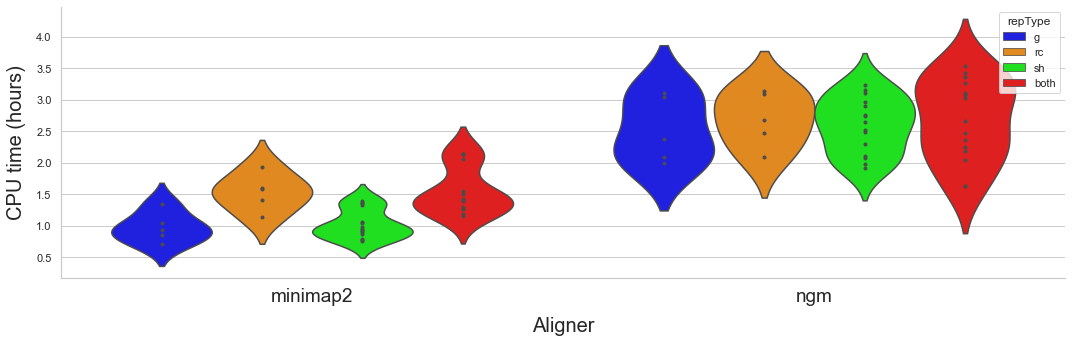

In [163]:
plot_stats(avg_df_stats, 'cpu', 'CPU time (hours)')

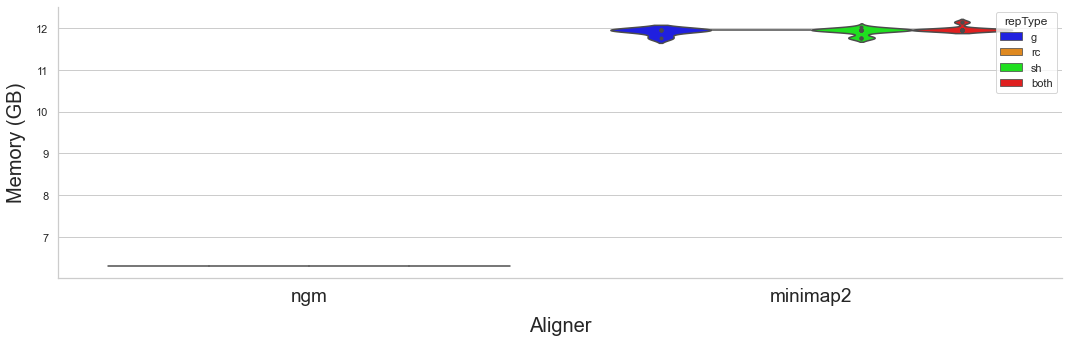

In [164]:
plot_stats(avg_df_stats, 'ram' ,'Memory (GB)')

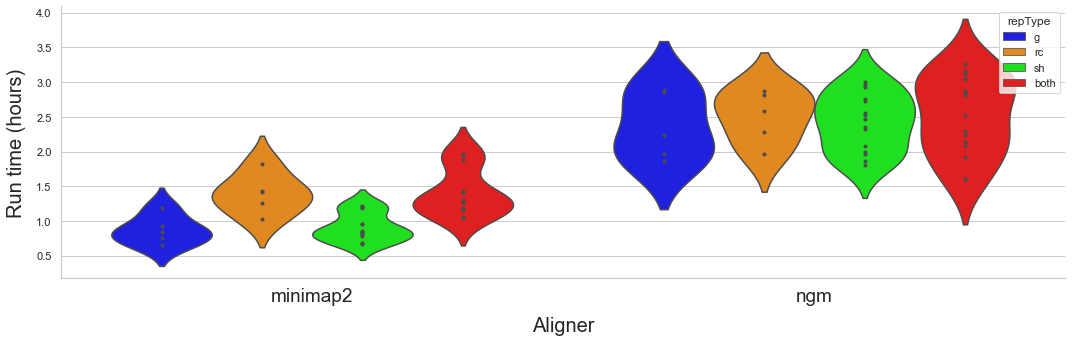

In [165]:
plot_stats(avg_df_stats, 'utime' ,'Run time (hours)')